In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define the set_size function for LaTeX-friendly figures
def set_size(width, fraction=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float
        Document width in points.
    fraction: float, optional
        Fraction of the width which you wish the figure to occupy.
    subplots: tuple, optional
        The number of rows and columns of subplots.

    Returns
    -------
    tuple
        Dimensions of figure in inches.
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio for aesthetic figure height
    golden_ratio = (5 ** 0.5 - 1) / 2

    # Figure width and height in inches
    fig_width_in = fig_width_pt * inches_per_pt
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

# Load your data
df = pd.read_csv("../data/dual_depth_peaks.csv")  # Replace with your actual file path

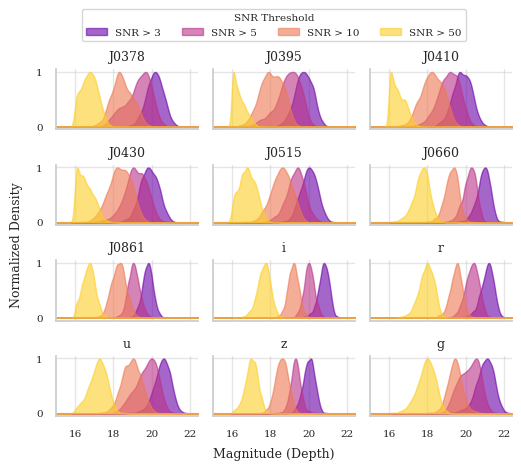

In [79]:
from scipy.stats import gaussian_kde


# Apply custom plot settings
col_width = 242.2665  # pt
fig_size = set_size(col_width, fraction=1.0, subplots=(3, 3))  # 3 rows, 3 columns for bigger boxes

# Custom paper settings for LaTeX-ready plots
paper_settings = {
    "text.usetex": False,
    "font.family": "serif",
    "font.size": 9,
    "axes.labelsize": "medium",
    "axes.titlesize": "medium",
    "figure.labelsize": "medium",
    "figure.titlesize": "medium",
    "legend.fontsize": "small",
    "legend.title_fontsize": "small",
    "xtick.labelsize": "small",
    "ytick.labelsize": "small",
    "axes.grid": True,
    "grid.alpha": 0.5,
    "figure.constrained_layout.use": False,
    "savefig.transparent": True,
}
plt.rcParams.update(paper_settings)


# Custom function to plot manually normalized KDEs
def plot_normalized_kde(data, color, label, **kwargs):
    kde = gaussian_kde(data)
    x_vals = np.linspace(15, 22.4, 500)
    y_vals = kde(x_vals)
    
    # Normalize the KDE so the peak is 1
    y_vals /= y_vals.max()
    
    plt.fill_between(x_vals, y_vals, alpha=0.6, color=color, label=label)

# Create FacetGrid
g = sns.FacetGrid(df, col="band", col_wrap=3, height=fig_size[1]*0.5, aspect=fig_size[0] / fig_size[1], sharex=True, sharey=True)

# Map the custom normalized KDE plotting function
palette = plt.cm.plasma(np.linspace(0.2, 0.9, len(snr_labels)))
snr_labels = sorted(df["snr_value"].unique())

def map_kde(data, **kwargs):
    for snr_value, color in zip(snr_labels, palette):
        snr_data = data[data["snr_value"] == snr_value]["peak"]
        if not snr_data.empty:
            plot_normalized_kde(snr_data, color=color, label=f"SNR > {snr_value}")

g.map_dataframe(map_kde)

# Customize axis labels and titles

# Add shared x and y labels for the entire figure
g.fig.supxlabel('Magnitude (Depth)', fontsize='medium', y=-0.02)  # Adjust `y` to position the label
g.fig.supylabel('Normalized Density', fontsize='medium', x=-0.025)  # Adjust `x` to position the label

g.set_titles("{col_name}")

# Set x-axis limits for all subplots
g.set(xlim=(15, 22.4))

# Add a single legend outside the plots
handles, labels = plt.gca().get_legend_handles_labels()
g.fig.legend(handles, labels, title="SNR Threshold", loc='upper center', bbox_to_anchor=(0.5, 1.08), ncol=len(snr_labels))

# Add a title on top, ensuring it doesn't overlap with the legend
#g.fig.suptitle("Depth Distribution per Band Colored by SNR Threshold", fontsize=10, y=1.12)

# Save the figure with proper LaTeX-friendly sizing
plt.savefig("../plots/depth_distribution_per_band_normalized.pdf", bbox_inches='tight', dpi=300)

plt.show()

In [80]:
df

,field,band,peak,snr_value
0,SPLUS-s23s16.fits,J0378,19.908354,3
1,SPLUS-s23s16.fits,J0378,18.755802,5
2,SPLUS-s23s16.fits,J0378,18.055687,10
3,SPLUS-s23s16.fits,J0378,16.904848,50
4,SPLUS-s23s16.fits,J0395,19.633686,3
...,...,...,...,...
101735,SPLUS-s26s20.fits,z,16.752815,50
101736,SPLUS-s26s20.fits,g,20.705814,3
101737,SPLUS-s26s20.fits,g,19.516178,5
101738,SPLUS-s26s20.fits,g,19.429098,10


In [103]:
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde

# Lista de SNRs para filtrar
snr_thresholds = [50, 10, 5, 3]

# DataFrame para armazenar os resultados
result = pd.DataFrame()

# Função para encontrar o pico da densidade (KDE) e calcular erros superiores e inferiores
def find_kde_peak_and_errors(data):
    kde = gaussian_kde(data)
    x_vals = np.linspace(data.min(), data.max(), 200)
    y_vals = kde(x_vals)
    
    # Encontrar o pico da densidade
    peak = x_vals[np.argmax(y_vals)]
    
    # Calcular percentis para erros assimétricos
    q25, q75 = np.percentile(data, [25, 75])
    
    # Erro inferior: distância do pico ao 25º percentil
    err_inf = peak - q25
    
    # Erro superior: distância do 75º percentil ao pico
    err_sup = q75 - peak
    
    return peak, err_sup, err_inf

# Calculando o pico da curva e erros para cada banda e limite de SNR
for snr in snr_thresholds:
    filtered = df[df['snr_value'] == snr]
    
    # Aplicar a função find_kde_peak_and_errors para cada banda
    peak_kde = filtered.groupby('band')['peak'].apply(find_kde_peak_and_errors).reset_index()
    
    # Separar os resultados em colunas distintas
    peak_kde[['peak', 'err_sup', 'err_inf']] = pd.DataFrame(peak_kde['peak'].tolist(), index=peak_kde.index)
    
    # Renomear as colunas para refletir o SNR
    peak_kde.rename(columns={
        'peak': f'S/N > {snr}',
        'err_sup': f'S/N > {snr} Err Sup',
        'err_inf': f'S/N > {snr} Err Inf'
    }, inplace=True)
    
    if result.empty:
        result = peak_kde
    else:
        result = pd.merge(result, peak_kde, on='band', how='outer')

# Organizando o DataFrame pela ordem desejada das bandas
bands_order = ['u', 'J0378', 'J0395', 'J0410', 'J0430', 'g', 'J0515', 'r', 'J0660', 'i', 'J0861', 'z']
result['band'] = pd.Categorical(result['band'], categories=bands_order, ordered=True)
result.sort_values('band', inplace=True)

# Arredondar os valores para 1 casa decimal
cols_to_round = [col for col in result.columns if col != 'band']
result[cols_to_round] = result[cols_to_round].round(2)

# Exibir o DataFrame resultante
print(result)

     band  S/N > 50  S/N > 50 Err Sup  S/N > 50 Err Inf  S/N > 10  \
10      u     17.26              0.25              0.37     19.03   
0   J0378     16.78              0.26              0.35     18.30   
1   J0395     16.10              0.48             -0.01     17.89   
2   J0410     16.11              0.63             -0.05     18.23   
3   J0430     16.12              0.69             -0.07     18.19   
7       g     18.00              0.26              0.35     19.43   
4   J0515     16.79              0.31              0.31     18.62   
9       r     17.99              0.22              0.30     19.55   
5   J0660     17.81              0.14              0.37     19.37   
8       i     17.75              0.12              0.33     19.22   
6   J0861     16.77              0.15              0.30     18.36   
11      z     16.97              0.26              0.17     18.60   

    S/N > 10 Err Sup  S/N > 10 Err Inf  S/N > 5  S/N > 5 Err Sup  \
10              0.24              